# Reinforcement Learning on 2048
Created 25.06.2025

In [1]:
import numpy as np
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipyevents import Event
import time
import gymnasium as gym
import torch
from IPython.display import HTML

In [2]:
sys.path.insert(1, str(Path("..")))
import andreas2048
from andreas2048.game import *

In [3]:
from andreas2048 import gym2048
#env = gym.make("andreas_2048")
env = gym2048.Env2048()

In [4]:
raise RuntimeError("STOP")

RuntimeError: STOP

### 1 Interactive game

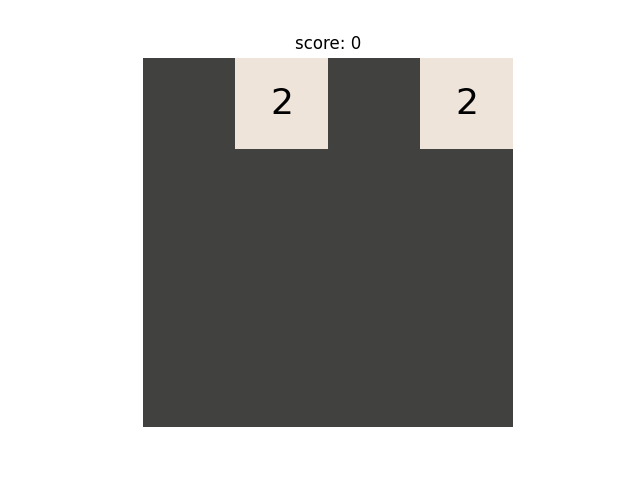

In [7]:
%matplotlib widget

game = andreas2048.Game(shape=(4,4))
plot_arrows = False
stdout = sys.stdout

def on_press(e):
    global plot_arrows, stdout
    if not game.alive:
        return
    match e.key:
        case "left":
            r = game.next(Action.LEFT)
        case "right":
            r = game.next(Action.RIGHT)
        case "up":
            r = game.next(Action.UP)
        case "down":
            r = game.next(Action.DOWN)
        case "r":
            plot_arrows = not plot_arrows
        case "z":
            game.undo()
        case _:
            r = False
    game.plot_on_axis(ax, plot_arrows=plot_arrows)
    fig.canvas.draw()

fig, ax = plt.subplots()
fig.canvas.mpl_connect('key_press_event', on_press)
game.plot_on_axis(ax)
plt.show()

In [12]:
len(game.state.get_next_states(Action.DOWN))

28

In [ ]:
def heuristic(game: Game) -> float:
    empty = np.count_nonzero(game.grid == 0)
    merges = np.count_nonzero(game.idx_is_merge(game.tile_history[-1]))
    power_sum = np.sum([int(a)**3.5 for a in game.grid.flatten() if a != 0])
    monotonic_left = 0
    monotonic_right = 0
    monotonic_up = 0
    monotonic_down = 0
    for i in range(game.grid.shape[0]):
        for j in range(1,game.grid.shape[1]):
            if game.grid[i,j] > game.grid[i,j-1]:
                monotonic_right += int(game.grid[i,j])**4 - int(game.grid[i,j-1])**4
            else:
                monotonic_left += game.grid[i,j-1]**4 -game.grid[i,j]**4
    for j in range(game.grid.shape[1]):
        for i in range(1,game.grid.shape[0]):
            if game.grid[i,j] > game.grid[i-1,j]:
                monotonic_down += int(game.grid[i,j])**4 - int(game.grid[i-1,j])**4
            else:
                monotonic_up += int(game.grid[i-1,j])**4 - int(game.grid[i,j])**4
    print(empty, merges, power_sum, monotonic_left, monotonic_right, monotonic_up, monotonic_down)
    return float(200_000 + empty*270 + merges*700 - power_sum*11 + max(monotonic_left, monotonic_right, monotonic_up, monotonic_down)*47)

print(heuristic(game))

9 0 341.58757749081815 0 706 0 643
231854.536647601


In [ ]:
game.tile_history[-1]

array([[0, 1, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 0],
       [0, 0, 0, 0]], dtype=uint8)

In [ ]:
np.count_nonzero(game.tile_history == 0)

14

In [ ]:
def heuristic(game: Game):
    
    empty = np.count_nonzero(game.grid == 0)
    merges =

heuristic(game)

In [ ]:
html = game.render_game(plot_arrows=True).to_jshtml()
plt.close()
HTML(html)

### 2 Random game

Played 1000 games in 13.188 s


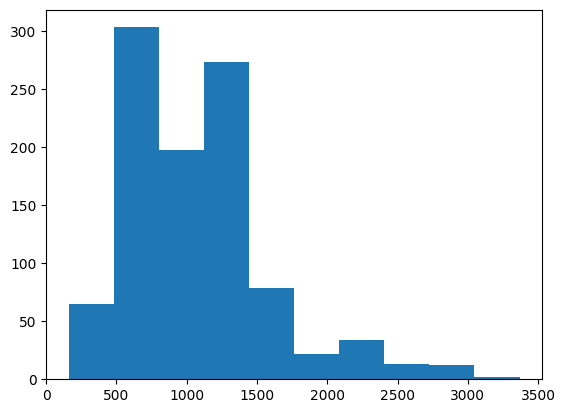

In [ ]:
n = 1000
score = []

t0 = time.perf_counter()
for i in range(n):
    game = Game()
    while game.alive:
        game.next(np.random.choice(np.array(game.get_moves())))
    score.append(game.score)
t1 = time.perf_counter()
print(f"Played {n} games in {(t1-t0):1.3f} s")

plt.hist(score)
plt.show()

<2048 Game (Ended): score 1140 and 122 moves lead to 128 as highest tile>
[[  2   4   2   4]
 [ 32 128   8  16]
 [  8  32  16   8]
 [  4   8   2   4]]


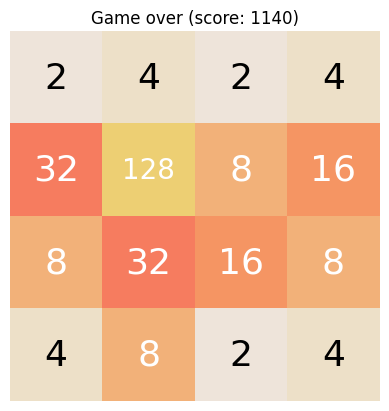

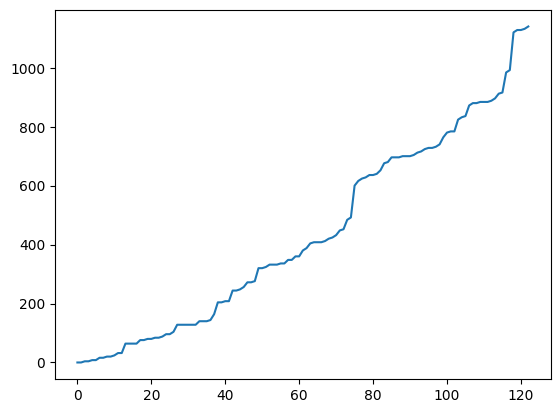

In [ ]:
%matplotlib inline
game = Game()

while game.alive:
    game.try_move(np.random.choice(np.array(game.get_moves())))

print(game)
ax = plt.subplot()
game.plot_on_axis(ax)
plt.show()

plt.plot(game.score_history)
plt.show()

### 3 Gymnasium

In [ ]:
from gymnasium.utils.env_checker import check_env

try:
    check_env(env)
    print("Environment passes all checks!")
except Exception as e:
    print(f"Environment has issues: {e}")

##### 3.1 Testing some dummy policies

In [ ]:
class Random_Policy:

    def __init__(self, env: gym.Env) -> None:
        self.env = env

    def get_action(self, obs: np.ndarray) -> Action:
        return np.random.choice([Action.UP, Action.DOWN, Action.LEFT, Action.RIGHT])
    

class RDPolicy():
    def __init__(self, env: gym2048.Env2048) -> None:
        self.env = env

    def get_action(self, obs: np.ndarray) -> Action:
        moves = self.env.game.get_moves()
        for a in [Action.DOWN, Action.RIGHT, Action.LEFT, Action.UP]:
            if a in moves:
                return a

In [ ]:
class DQN_Agent:

    def __init__(self, env: gym.Env) -> None:
        self.env = env

    def get_action(self, obs: np.ndarray) -> Action:
        pass

    def build_model(self):
        self.model =  torch.nn.Sequential(
            torch.nn.Linear(4*4*16, out_features=128), 
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=128, out_features=128),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=128,out_features=4)
        )

In [ ]:
from matplotlib.ticker import FuncFormatter, MaxNLocator


agent = RDPolicy(env)
scores = []
highest_tiles = []
move_counts = []

for episode in range(100):
    # Start a new hand
    obs, info = env.reset()
    done = False

    # Play one complete hand
    while not done:
        # Agent chooses action (initially random, gradually more intelligent)
        action = agent.get_action(obs)

        # Take action and observe result
        next_obs, reward, terminated, truncated, info = env.step(action)

        # Learn from this experience
        #agent.update(obs, action, reward, terminated, next_obs)

        # Move to next state
        done = terminated or truncated
        obs = next_obs
    scores.append(env.game.score)
    highest_tiles.append(env.game.highest_tile)
    move_counts.append(env.game.move_count)

ax1 = plt.subplot()
ax2 = ax1.twinx()
ax3 = ax1.twinx()
ax3.spines.right.set_position(("axes", 1.2))
ax1.plot(scores, label="Scores")
p2 = ax2.plot(np.log2(highest_tiles), label="Highest tile", c="orange")
p3 = ax3.plot(move_counts, label="Move count", c="green")
ax1.set_xlabel("Episode")
ax1.set_ylabel("Score")
ax2.set_ylabel("Highest Tile")
ax3.set_ylabel("Move count")
ax2.yaxis.label.set_color(p2[0].get_color())
ax3.yaxis.label.set_color(p3[0].get_color())
ax2.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{2**x:n}"))
ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()